# Setup #

In [13]:
# Make sure these libraries are installed on local computer
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

import cv2
from PIL import Image
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

import os
import math

# Detection algorithm works with an NxN matrix
#N is a power of 2
N = 32

#Name the image
name = "Sunny_Capybara"

#Path of image to use
# path = os.path.join("test_images", "squarecapybara.jpg")
path = os.path.join("test_images", "timothycapybara.png")

# Helper Functions #

In [14]:
def plot_image(img, title: str):
    plt.title(title)
    
    if img.shape[0] <= 32:
        plt.xticks(range(img.shape[0]))
        plt.yticks(range(img.shape[1]))
    
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

For [QPIE](#QPIE), we're encoding each pixel value into amplitudes of the quantum state. As a result, we need

$\sum _{} ^{} c_i^2 = 1$, since all probabilities much add up to one.

To accomplish this while maintaining relative differences, we set

$c_i = \frac{c_i}{\sqrt{\sum c_i ^2}}$ (Divide by Root mean squared)

so now 

$\sum _{} ^{} (\frac{c_i}{\sqrt{\sum c_i ^2}})^2 = \frac{1}{\sum _{} ^{} c_i^2} \cdot \sum _{} ^{} c_i^2 = 1$, as desired


In [15]:
#Normalize -- squared amplitudes must sum to 1
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Image Preprocessing #

In [16]:
#Input Processing to np array

img_raw = np.asarray(Image.open(path))
# img_raw = plt.imread('/test_images/test_image1.jpg')

n = img_raw.shape[0]
m = img_raw.shape[1]
#n, m, k = img_raw.shape

print('Raw Image info:', img_raw.shape)
print('Raw Image datatype:', img_raw.dtype)

if n != m:
    raise Exception("Image must be square")

if n % N != 0:
    raise Exception(f"Image cannot be converted to an {N} by {N} matrix")

# we need to "reduce" each sz X sz grid
# sz is size
sz = n // N


Raw Image info: (32, 32, 4)
Raw Image datatype: uint8


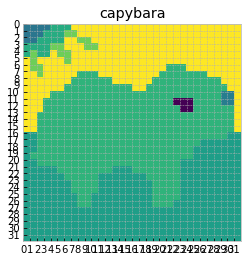

In [17]:
img = np.zeros(shape=(N, N))

for i in range(0, n, sz):
    for j in range(0, n, sz):
        #This will be a single cell in final pixel
#         val = np.sum(img_raw[i:i+sz, j:j+sz]) / 255
        val = np.sum(img_raw[i:i+sz, j:j+sz][0]) / 255
#         val = np.sum(img_raw[i:i+sz, j:j+sz][1]) / 255
#         val = np.sum(img_raw[i:i+sz, j:j+sz][2]) / 255

#        val = 0
#         for k in range(0, sz):
#             val += np.sum(img_raw[i + k][j:j+sz][0]) / 255
            
        img[i//sz][j//sz] = val

plot_image(img, "capybara")

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$

In [QPIE](#QPIE), we're indexing the grid as $\ket{\text{Img}} = \sum _{i=0} ^{2^n-1} grid[\frac{i}{N}][i \mod N] \ket{i}$.

Therefore, if we obtain differences between adjacent indicies, it will only obtain horizontal differences:

![Horizontal Grid Differences](https://github.com/timothygao8710/Capybaras-Capstone-Project/blob/main/explanation_diagrams/scuffed_HDiff.png?raw=true)

(the red indicates the differences)

In order to obtain all differences for the entire 2D grid, one solution is to simply take the transpose the image, then apply the entire algorithm to both images.

![Vertical Grid Differences](https://github.com/timothygao8710/Capybaras-Capstone-Project/blob/main/explanation_diagrams/scuffed_VDiff.png?raw=true)

When we combine both images together at the end we will now have adjacent differences both vertically and horizontally.

In [18]:
# Horizontal: Original image
image_norm_h = amplitude_encode(img)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(img.T)

# Quantum Part - Algorithm #

<a id='QPIE'></a>
## Quantum Probability Image Encoding (QPIE) ##

### Based on [Paper](https://arxiv.org/pdf/2012.11036.pdf) ###

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$

Basic idea:

Recall each element in our processed image grid represents the color intensity in that cell.

Let's assign $c = grid[i][j]$, and index of $c$ as $i * N + j$.

In QPIE representation, the image becomes 

$\ket{\text{Img}} = \sum _{i=0} ^{2^n-1} c_i \ket{i}$ or $\ket{\text{Img}} = \sum _{i=0} ^{2^n-1} grid[\frac{i}{N}][i \mod N] \ket{i}$ (n is number of qubits)

This means that we need $n = \lceil \log_2N^2 \rceil$ qubits in order to index all $N^2$ pixels in our image.

In order to actually achieve the desired amplitudes ($c$) for all quantum states states, we can use a combination of CNOT and Aritrary Rotation Gates.

For example, to encode (0, 128, 192, 255):

![quantum state preparation](https://qiskit.org/textbook/ch-applications/images/state_prep.png)

Quiskit has a nice implementation of this algorithm for us [here](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.initialize.html), which we can call through .initialize() on the QuantumCircuit.

Time complexity: $\mathcal{O}(n)$ = $\mathcal{O}(log(N^2))$

In [42]:
# qubit amount
# data_qb should be math.ceil(math.log2(N))
data_qb = math.ceil(math.log2(N**2))
anc_qb = 1
total_qb = data_qb + anc_qb

print(total_qb)

11


In [43]:
# horizontal scan circuit
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
display(qc_h.draw('mpl', fold=-1))

TypeError: initialize() takes from 2 to 3 positional arguments but 4 were given

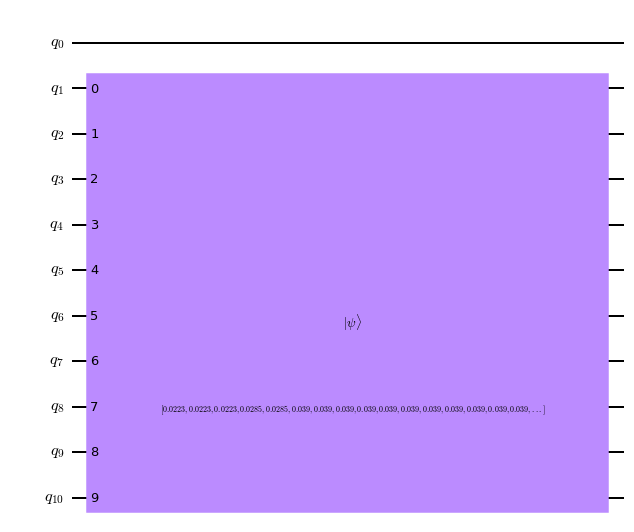

In [21]:
# vertical scan circuit
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
display(qc_v.draw('mpl', fold=-1))

## Quantum Hadamard Edge Detection (QHED) ##

### Based on [Paper](https://arxiv.org/abs/1801.01465) ###

$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
$

### Part 1 ###
The first is a simple Hadamard Gate on qubit 0, which is the least significant bit (LSB) in our indexing and highlighted in red below:

Index 0: $00\color{red}{0}$

Index 1: $00\color{red}{1}$

Index 2: $01\color{red}{0}$

Index 3: $01\color{red}{1}$

Index 4: $10\color{red}{0}$

Index 5: $10\color{red}{1}$

$. . .$
(Example with 3 qubits)

Notice how it alternates, which makes sense when we consider $\mod 2$. This property works neatly with a Hadamard Gate. Recall the definition of a Hamadard Gate:

$
|0 \rangle \rightarrow \frac{(|0 \rangle + |1 \rangle)}{\sqrt{2}} \\
|1 \rangle \rightarrow \frac{(|0 \rangle - |1 \rangle)}{\sqrt{2}}
$

So let's consider applying the Hamadard Gate on the LSB (0th qubit)

Peforming this action ($H_0$) on Index 0 (Let's donate this as $I_{2^n - 1}[0]$) yields:

$ \frac{1}{\sqrt{2}} $ $c_0 |000 \rangle + c_0 |001 \rangle)$

$H_0$ on $I_{2^n - 1}[1]$ yields:

$ \frac{1}{\sqrt{2}} $ $c_1 |000 \rangle - c_1 |001 \rangle)$

$H_0$ on $I_{2^n - 1}[2]$ yields:

$ \frac{1}{\sqrt{2}} $ $c_2 |010 \rangle + c_2 |010 \rangle)$

The signs will alternate, because the LSB alternates.

Formally, we are performing $I_{2^{n-1}} \otimes H_0$.

The Hadamard Gate $H$ is defined as 

$\tfrac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$

$\downarrow$

$
I_{2^{n-1}} \otimes H_0 = \frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & 1 & 0 & 0 & \dots & 0 & 0 \\
1 & -1 & 0 & 0 & \dots & 0 & 0 \\
0 & 0 & 1 & 1 & \dots & 0 & 0 \\
0 & 0 & 1 & -1 & \dots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \dots & 1 & 1 \\
0 & 0 & 0 & 0 & \dots & 1 & -1 \\
\end{bmatrix}$

Applying this unitary to the QPIE representation $\ket{\text{Img}} = \sum_{i=0} ^{N-1} c_i \ket{i}$

$
(I_{2^{n-1}} \otimes H_0) \cdot
\begin{bmatrix}
c_0 \\
c_1 \\
c_2 \\
c_3 \\
\vdots \\
c_{N-2} \\
c_{N-1} \\
\end{bmatrix}
\rightarrow \frac{1}{\sqrt{2}}
\begin{bmatrix}
c_0 + c_1 \\
c_0 - c_1 \\
c_2 + c_3 \\
c_2 - c_3 \\
\vdots \\
c_{N-2} + c_{N-1} \\
c_{N-2} - c_{N-1} \\
\end{bmatrix}
$

This matrix gives us access to the gradient between the pixel intensities of neighboring pixels $c_i$ and $c_{i+1}$, through $(c_i - c_{i+1})$.

Intuitively, this should also make sense, again considering the alternating LSB between 0/1 and how $H$ changes the sign accordingly.

This Hadamard gate is applied in $\mathcal{O}(1)$ on a quantum computer, allowing us the compute adjacent-cell-differences very quickly, while on a classical computer the same algorithm takes time proportional to the number of pixels, which is $N^2$ or $2^n$.

Time Complexity: $\mathcal{O}(1)$

### Part 2 ###

However, this only obtains the horizontal pixel differences for even-odd pixel pairs, if we examine the matrix closely.

(Highlighted in red below for n = 3 example)
![Even-odd pixel pairs](https://github.com/timothygao8710/Capybaras-Capstone-Project/blob/main/explanation_diagrams/scuffed_even_odd.png?raw=true)

One way to account for this is by performing an amplitude permutation, shifting the entire register right and wrapping around the rightmost element:

![Amp Perm](https://github.com/timothygao8710/Capybaras-Capstone-Project/blob/main/explanation_diagrams/scuffed_amp_permutation.png?raw=true)

^ Amplitude permutation 

![Odd-even pixel pairs](https://github.com/timothygao8710/Capybaras-Capstone-Project/blob/main/explanation_diagrams/scuffed_odd_even.png?raw=true)

^ Result after permutating

This gives us access to also the odd-even pixel pairs now, so we now have all adjacent pixel differences. In post-processing, we can take care not to include irrelevant differences like ($c_5 - c_0$).

We can easily perform this permutation operation with the unitary

$
D_{2^{n+1}} =
\begin{bmatrix}
0 & 1 & 0 & 0 & \dots & 0 & 0 \\
0 & 0 & 1 & 0 & \dots & 0 & 0 \\
0 & 0 & 0 & 1 & \dots & 0 & 0 \\
0 & 0 & 0 & 0 & \dots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \dots & 0 & 1 \\
1 & 0 & 0 & 0 & \dots & 0 & 0 \\
\end{bmatrix}
$

In practice, we don't actually rotate. Instead, this unitary just "extends", as follows:
$(c_0, c_0, c_1, c_1, c_2, c_2, \dots, c_{N-2}, c_{N-2}, c_{N-1}, c_{N-1})^T \rightarrow (c_0, c_1, c_1, c_2, c_2, c_3, \dots, c_{N-2}, c_{N-1}, c_{N-1}, c_0)^T$

This is why we need an extra ancillary qubit.

If only we could apply this transformation directly to our quantum state...

Well, it turns out we can! This unitary actually correponds to the Decrement gate. Hence, we can efficently decompose this unitary into a set of single- and multi-controlled-X rotations on a register of multiple qubits as shown by [Fijany and Williams](https://arxiv.org/abs/quant-ph/9809004) and [Gidney](https://algassert.com/circuits/2015/06/12/Constructing-Large-Increment-Gates.html).

In Qiskit, we can use [this function](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.unitary.html) to directly apply the matrix transformation to our quantum state, with .unitary().

So after utilizing the unitary:
$
(I_{2^{n}} \otimes H) \cdot
\begin{bmatrix}
c_0 \\
c_1 \\
c_1 \\
c_2 \\
c_2 \\
c_3 \\
\vdots \\
c_{N-2} \\
c_{N-1} \\
c_{N-1} \\
c_0 \\
\end{bmatrix}
\rightarrow
\begin{bmatrix}
c_0 + c_1 \\
c_0 - c_1 \\
c_1 + c_2 \\
c_1 - c_2 \\
c_2 + c_3 \\
c_2 - c_3 \\
\vdots \\
c_{N-2} + c_{N-1} \\
c_{N-2} - c_{N-1} \\
c_{N-1} + c_0 \\
c_{N-1} - c_0 \\
\end{bmatrix}
$

Now, we have access to the resultant horizontal gradient values $c_i - c_{i+1}$ for all possible pairs of adjacent qubits.

Time Complexity: $\mathcal{O}(n)$ from applying the unitary.

In [22]:
# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

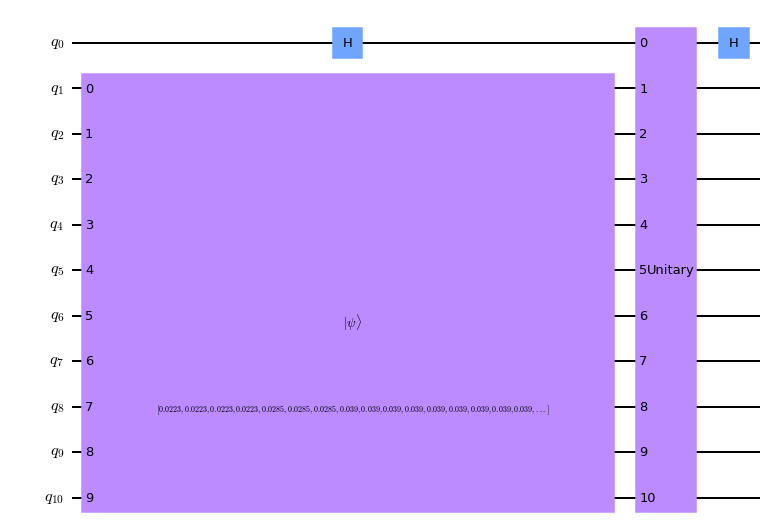

In [23]:
#QHED for horizontal scan circuit
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

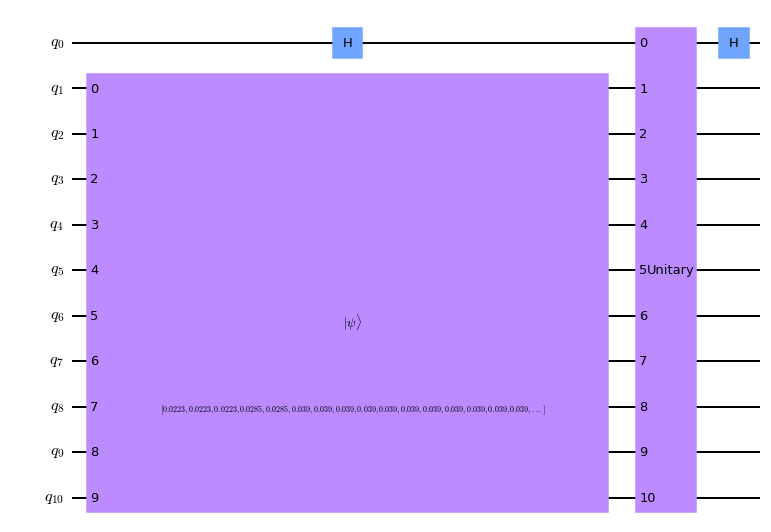

In [24]:
#QHED for vertical scan circuit
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

In [25]:
# Store both circuits in a list, so we can run both circuits in one simulation later
circ_list = [qc_h, qc_v]

## Statevector Quantum Simulation ##

In [26]:
# Simulating the circuits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

# Classical Postprocessing

To use our results from QHED, we mark notable edges by "thresholding", i.e., marking cells that have significant adjacent differences as edges.

We store the marked/unmarked cells as a binary value (1 for marked, 0 for unmarked).

Finally, we can combine our vertical transposed image results with the horizontal original image results with a simple OR operator

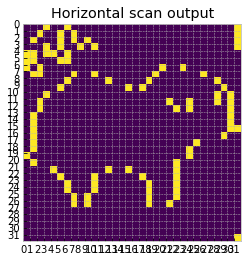

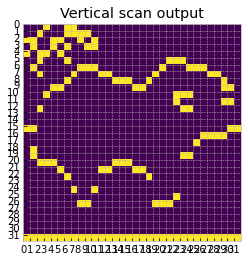

In [27]:
# Classical postprocessing for plotting the output

# Defining a lambda function for thresholding difference values
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(N, N)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(N, N).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

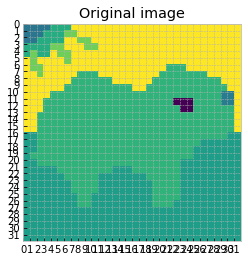

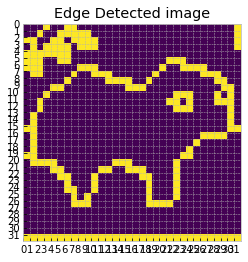

In [28]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(img, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')

# Quantum Part - Hardware #

In [29]:
# load account
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [30]:
# get provider and backend
provider = IBMQ.get_provider(hub='ibm-q', group='open')

backend = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_manila


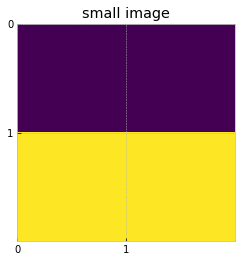

In [31]:
# create 2x2 to run on hardware
img_small = np.array([[0, 0], [1, 1]])

# plot image
plot_image(img_small, "small image")

In [32]:
# initialize number of qubits
data_qb = 2
anc_qb = 1
total_qb = data_qb + anc_qb

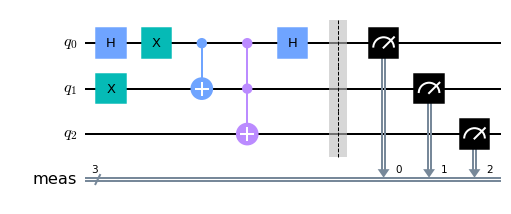

In [33]:
# horizontal scan circuit
qc_small_h = QuantumCircuit(total_qb)
qc_small_h.x(1)
qc_small_h.h(0)

# decrement gate - start
qc_small_h.x(0)
qc_small_h.cx(0, 1)
qc_small_h.ccx(0, 1, 2)
# finished decrementing gate

qc_small_h.h(0)
qc_small_h.measure_all()
display(qc_small_h.draw('mpl'))

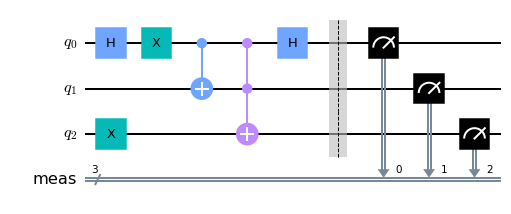

In [34]:
# vertical scan circuit
qc_small_v = QuantumCircuit(total_qb)
qc_small_v.x(2)
qc_small_v.h(0)

# decrement gate - START
qc_small_v.x(0)
qc_small_v.cx(0, 1)
qc_small_v.ccx(0, 1, 2)
# decrement gate finished

qc_small_v.h(0)
qc_small_v.measure_all()
display(qc_small_v.draw('mpl'))

# combine circuits
circ_list = [qc_small_h, qc_small_v]

In [35]:
# transpile circuits to optimize execution
qc_small_h_t = transpile(qc_small_h, backend=backend, optimization_level=3)
qc_small_v_t = transpile(qc_small_v, backend=backend, optimization_level=3)

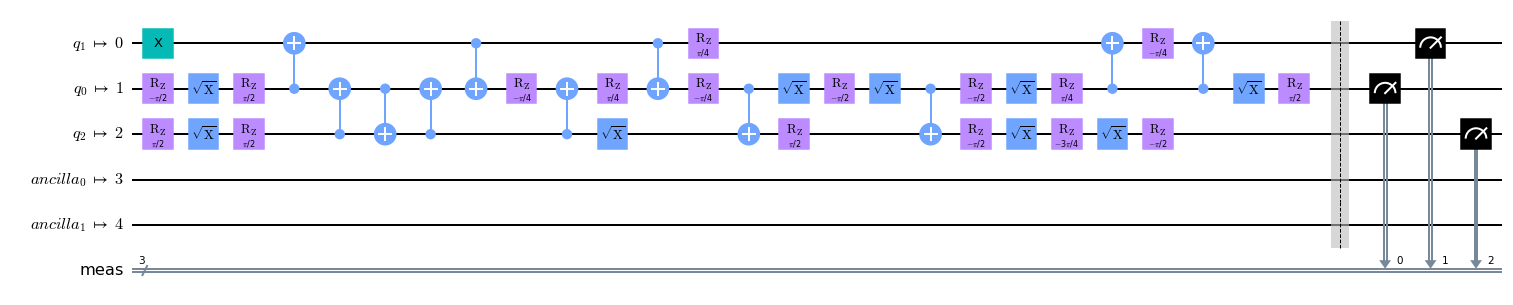

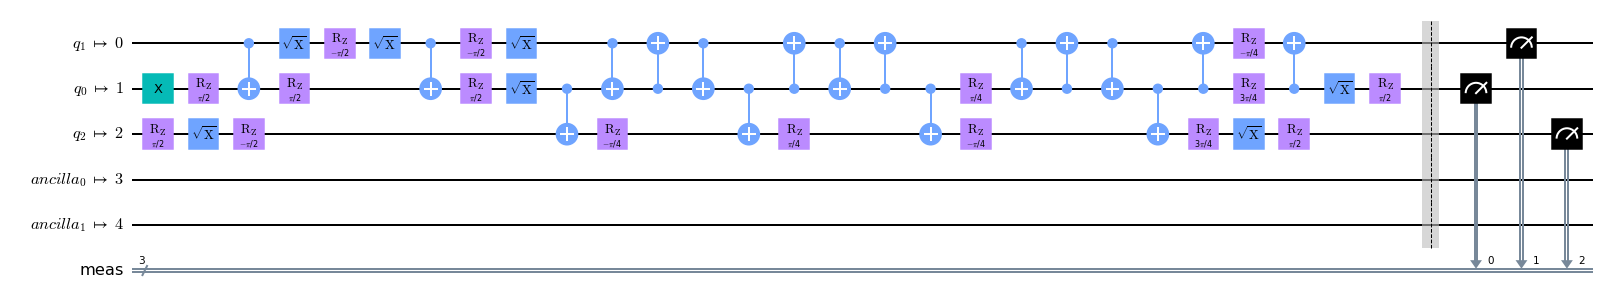

In [36]:
# combine into list
circ_list_t = [qc_small_h_t, qc_small_v_t]

# draw transpiled circuit
display(circ_list_t[0].draw('mpl', fold=-1))
display(circ_list_t[1].draw('mpl', fold=-1))

In [37]:
job = execute(circ_list_t, backend=backend, shots=8192)
job_monitor(job)

Job Status: job has successfully run


Counts for horizontal scan:


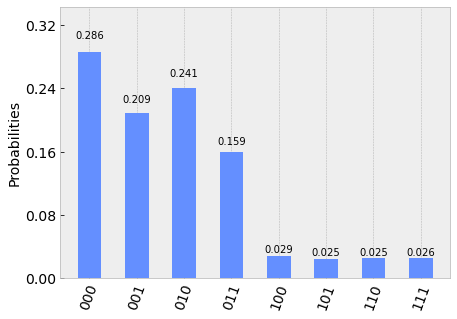



Counts for vertical scan:


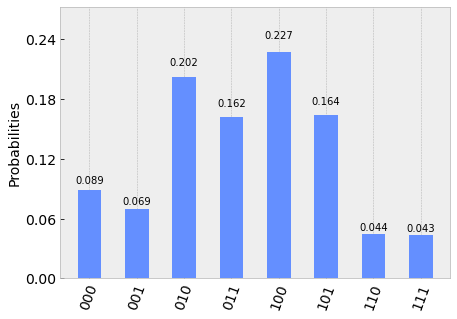

In [38]:
result = job.result()
counts_h = result.get_counts(qc_small_h)
counts_v = result.get_counts(qc_small_v)

print('Counts for horizontal scan:')
display(plot_histogram(counts_h))

print("\n\nCounts for vertical scan:")
display(plot_histogram(counts_v))

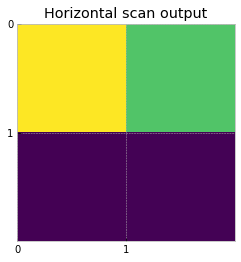

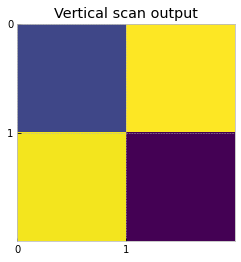

In [39]:
# Extracting counts for odd numbered states
edge_scan_small_h = np.array([counts_h[f'{2*i+1:03b}'] for i in range(2 ** data_qb)]).reshape(2, 2)
edge_scan_small_v = np.array([counts_v[f'{2*i+1:03b}'] for i in range(2 ** data_qb)]).reshape(2, 2).T

plot_image(edge_scan_small_h, 'Horizontal scan output')
plot_image(edge_scan_small_v, 'Vertical scan output')

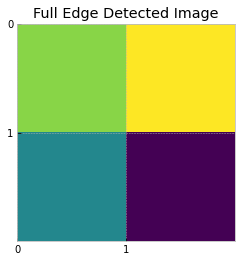

In [40]:
edge_detected_image_small = edge_scan_small_h + edge_scan_small_v

# plotting original and edge detected images
plot_image(edge_detected_image_small, 'Full Edge Detected Image')